In [0]:
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms, datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import cv2

from tqdm import tqdm
from fastprogress import progress_bar as pb

In [0]:
!cp  './drive/My Drive/bear_cropped.zip' .

In [0]:
!unzip bear_cropped.zip -d bear_cropped > /dev/null

In [0]:
img_cropped_filepaths = glob.glob('./bear_cropped/img/bear_cropped/*', recursive=True)

In [6]:
len(img_cropped_filepaths)

1294

./bear_cropped/img/bear_cropped/274463_0.jpg


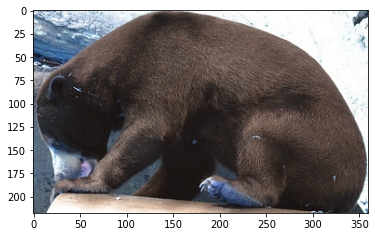

./bear_cropped/img/bear_cropped/258337_1.jpg


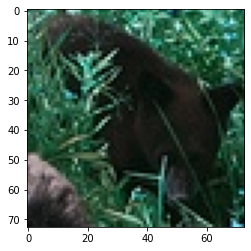

./bear_cropped/img/bear_cropped/199427_0.jpg


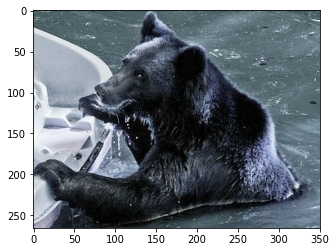

./bear_cropped/img/bear_cropped/551739_0.jpg


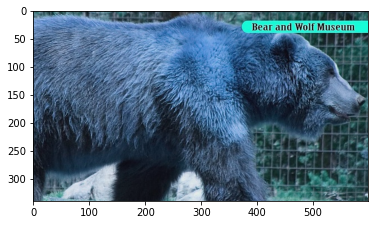

./bear_cropped/img/bear_cropped/328499_1.jpg


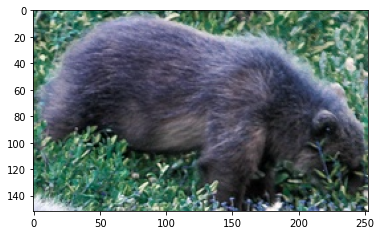

./bear_cropped/img/bear_cropped/152898_0.jpg


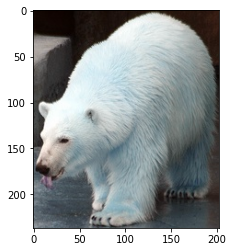

./bear_cropped/img/bear_cropped/443916_15.jpg


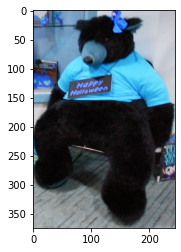

./bear_cropped/img/bear_cropped/381350_2.jpg


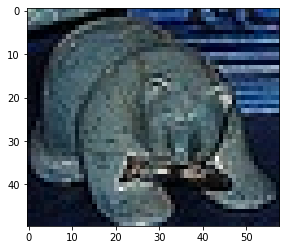

./bear_cropped/img/bear_cropped/522611_0.jpg


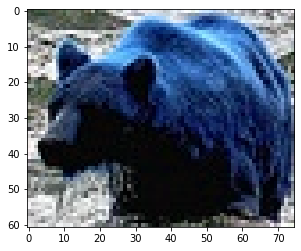

./bear_cropped/img/bear_cropped/495079_0.jpg


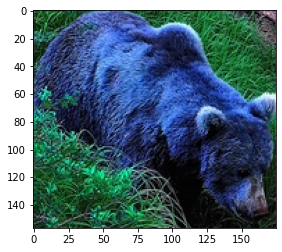

In [7]:
for img_filepath in img_cropped_filepaths[:10]:
    print(img_filepath)
    img = cv2.imread(img_filepath)
    plt.imshow(img)
    plt.show()

In [0]:
class CNNAutoEncoder2D(nn.Module):

    def __init__(self, input_dim_x=224, input_dim_y=224, in_channels=3, base_channel=124, latent_dim=100):
        super(CNNAutoEncoder2D, self).__init__()

        self._in_dim_x = input_dim_x
        self._in_dim_y = input_dim_y
        self._in_channels = in_channels

        self._encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channel, 4, 2, 1), 
            nn.BatchNorm2d(base_channel),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(base_channel, base_channel*2, 4, 2, 1), 
            nn.BatchNorm2d(base_channel*2),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(base_channel*2, base_channel*4, 4, 2, 1),
            nn.BatchNorm2d(base_channel*4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(base_channel*4, base_channel*8, 4, 2, 1),
            nn.BatchNorm2d(base_channel*8),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(base_channel*8, latent_dim, 4, 2),
            nn.BatchNorm2d(latent_dim),
            nn.LeakyReLU(negative_slope=0.1),
        )

        self._decorder1 = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, base_channel*8, kernel_size=4, stride=2),
            nn.BatchNorm2d(base_channel*8),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channel*8, base_channel*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channel*4),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channel*4, base_channel*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channel*2),
            nn.ReLU(),
            nn.ConvTranspose2d(base_channel*2, base_channel, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channel),
            nn.ConvTranspose2d(base_channel, self._in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        x = self._encoder1(x)
        return x

    def decode(self, x):
        x = self._decorder1(x)
        return x

    def _get_fc_layer_in_dim(self):
        dummy_data = torch.randn(3, self._in_channels, self._in_dim_x, self._in_dim_y)
        for layer in self._encoder1:
            dummy_data = layer(dummy_data)
        dummy_data = dummy_data.view(dummy_data.shape[0], -1)
        return dummy_data.shape[1]

In [0]:
ae_model = CNNAutoEncoder2D().to('cuda')

In [10]:
from torchsummary import summary
summary(ae_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 124, 112, 112]           6,076
       BatchNorm2d-2        [-1, 124, 112, 112]             248
         LeakyReLU-3        [-1, 124, 112, 112]               0
            Conv2d-4          [-1, 248, 56, 56]         492,280
       BatchNorm2d-5          [-1, 248, 56, 56]             496
         LeakyReLU-6          [-1, 248, 56, 56]               0
            Conv2d-7          [-1, 496, 28, 28]       1,968,624
       BatchNorm2d-8          [-1, 496, 28, 28]             992
         LeakyReLU-9          [-1, 496, 28, 28]               0
           Conv2d-10          [-1, 992, 14, 14]       7,873,504
      BatchNorm2d-11          [-1, 992, 14, 14]           1,984
        LeakyReLU-12          [-1, 992, 14, 14]               0
           Conv2d-13            [-1, 100, 6, 6]       1,587,300
      BatchNorm2d-14            [-1, 10

In [0]:
ae_model = CNNAutoEncoder2D().to('cuda')

In [12]:
ae_model(torch.randn(10, 3, 224, 224).float().to('cuda')).shape

torch.Size([10, 3, 224, 224])

In [0]:
class TrainImageTransform():

    def __init__(self, resize, mean, std):
        self._transform = transforms.Compose([
            transforms.RandomResizedCrop(
                resize, scale=(0.5, 1.0),
            ),
            transforms.RandomHorizontalFlip(),
            # transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            #transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self._transform(img)


class TestImageTransform():

    def __init__(self, resize, mean, std):
        self._transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            # transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            #transforms.Normalize(mean, std)
        ])
  
    def __call__(self, img):
        return self._transform(img)


In [0]:
class SpDataset(data.Dataset):

    def __init__(self, file_list, labels, transform):
        self._file_list = file_list
        self._labels = labels
        self._transform = transform

    def __len__(self):
        return len(self._file_list)

    def __getitem__(self, index):

        label = self._labels[index]
        img_path = self._file_list[index]
        img = Image.open(img_path).convert("RGB")

        img_transformed = self._transform(img)

        return img_transformed, label


In [0]:
train_imgs, test_imgs = train_test_split(img_cropped_filepaths, test_size=0.3)

In [0]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_dataset = SpDataset(
    file_list=train_imgs,
    labels=[1]*len(train_imgs),
    transform=TrainImageTransform(size, mean, std)
)
test_dataset = SpDataset(
    file_list=test_imgs,
    labels=[1]*len(test_imgs),
    transform=TestImageTransform(size, mean, std)
)

In [0]:
BATCH_SIZE = 16

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [0]:
batch, labels = next(iter(train_dataloader))

In [19]:
batch.shape

torch.Size([16, 3, 224, 224])

(array([  184.,   493.,   861.,  1501.,  2861.,  4865.,  7813., 10377.,
        11029., 10573.,  9256.,  8606.,  8200.,  9253.,  7725.,  7518.,
         7376.,  6507.,  5499.,  4443.,  3553.,  2845.,  2287.,  1858.,
         1617.,  1433.,  1398.,  1121.,  1078.,  1070.,  1029.,   917.,
          837.,   716.,   727.,   733.,   673.,   780.,   648.,   268.]),
 array([0.04705882, 0.07088235, 0.09470588, 0.11852941, 0.14235294,
        0.16617647, 0.19      , 0.21382353, 0.23764706, 0.2614706 ,
        0.28529412, 0.30911765, 0.33294117, 0.3567647 , 0.38058823,
        0.40441176, 0.4282353 , 0.45205882, 0.47588235, 0.49970588,
        0.5235294 , 0.54735297, 0.57117647, 0.595     , 0.6188235 ,
        0.6426471 , 0.6664706 , 0.69029415, 0.71411765, 0.7379412 ,
        0.7617647 , 0.78558826, 0.80941176, 0.8332353 , 0.8570588 ,
        0.8808824 , 0.9047059 , 0.92852944, 0.95235294, 0.9761765 ,
        1.        ], dtype=float32),
 <a list of 40 Patch objects>)

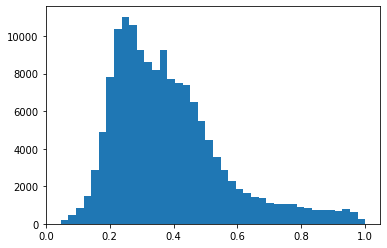

In [20]:
plt.hist(batch[0].flatten(), bins=40)

In [21]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
ae_model = CNNAutoEncoder2D().to('cuda')

In [0]:
_ = ae_model.train()

In [0]:
EPOCHS = 300

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_model.parameters(),
    lr=10e-3,
    weight_decay=1e-5
)

In [25]:
# 学習

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

ae_model.to('cuda')

for epoch in pb(range(EPOCHS)):
    print(epoch)

    # train

    ae_model.train()

    epoch_loss = 0.0
    epoch_corrects = 0

    for batch, labels in train_dataloader:

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            preds = ae_model(batch.to('cuda')).cpu()
            loss = criterion(preds, batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch.size(0)
            
    if epoch % 10 == 0:
        for i in range(batch.shape[0]):
            plt.figure(figsize=(9,5))
            plt.subplot(1,3,1)
            plt.title('original train')
            plt.imshow(batch[i].permute(1, 2, 0))
            plt.subplot(1,3,2)
            plt.title('decoded train')
            plt.imshow(preds[i].detach().permute(1, 2, 0))
            plt.subplot(1,3,3)
            plt.title('diff train')
            plt.imshow((batch[i].permute(1, 2, 0)-preds[i].detach().permute(1, 2, 0)).abs())
            plt.show()
    
    epoch_loss = epoch_loss / len(train_dataloader.dataset)
    train_loss_history.append(epoch_loss)

    print('Train Loss : {:.4f}'.format(epoch_loss))

    # validation

    ae_model.eval()

    epoch_loss = 0.0
    epoch_corrects = 0

    for batch, labels in test_dataloader:

        with torch.set_grad_enabled(False):
            preds = ae_model(batch.to('cuda')).cpu()
            loss = criterion(preds, batch)

            epoch_loss += loss.item() * batch.size(0)

    if epoch % 10 == 0:
        for i in range(batch.shape[0]):
            plt.figure(figsize=(9,5))
            plt.subplot(1,3,1)
            plt.title('original test')
            plt.imshow(batch[i].permute(1, 2, 0))
            plt.subplot(1,3,2)
            plt.title('decoded test')
            plt.imshow(preds[i].detach().permute(1, 2, 0))
            plt.subplot(1,3,3)
            plt.title('diff test')
            plt.imshow((batch[i].permute(1, 2, 0)-preds[i].detach().permute(1, 2, 0)).abs())
            plt.show()
    
    epoch_loss = epoch_loss / len(test_dataloader.dataset)
    test_loss_history.append(epoch_loss)

    print('Test Loss : {:.4f}'.format(epoch_loss))

    print("="*100)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
plt.plot(train_loss_history)